# Q-Learning

## Runing Q-learning for 100000 episodes<br>

  (a)The decreasing trend in epochs per episode during Q-learning training demonstrates the agent's improving efficiency as it learns the optimal actions to solve the Taxi-v3 task. The initial high number of epochs is due to exploration, while the eventual decrease results from exploiting learned knowledge stored in the Q-table. Fluctuations around 15 epochs in the later stages are expected due to the environment's randomness, continued exploration (epsilon-greedy), and varying task complexities. This value (15) likely represents a near-optimal number of steps for task completion.<br>

  (b) The penalty curve in the Taxi-v3 environment should be decreasing during Q-learning, indicating the agent's improvement in avoiding illegal actions. Penalties of 0 or 1 are most common, representing successful episodes or occasional single mistakes. Higher penalties, though less frequent, can arise from exploration, complex scenarios, imperfect learning, and local optima traps. These instances diminish as the agent refines its policy and becomes more adept at the task.<br>

  (c) Timesteps taken: 14, Penalties incurred: 0, Total reward (money earned): 7 <br>

  (d) Action 0 (south) has the highest Q-value. <br>

  (e) Action 1 (north) has the highest Q-value. In this scenario, the taxi is at (3, 1), and the passenger is at location B (4, 3). Moving north (action 1) would take the taxi one step closer to the passenger's location. Therefore, yes, it is reasonable to take action 1 (north) in state 332. The Q-learning algorithm has correctly learned that moving towards the passenger is a beneficial step towards completing the task. <br>

  (f) Average timesteps per episode: 12.98, Average penalties per episode: 0.0, Average reward per episode: 8.02 <br>

2. Change the Hyperparameters: <br>
  (a) The ephocs per episode dont as quickly it seems as much. Since the agent explores very little, it might get stuck in a suboptimal solution if it doesn't explore enough to find a better one.<br>

  (b) The penalties are mostly 0. The agent will explore much less and primarily exploit its existing knowledge from the Q-table. This is because the probability of choosing a random action is extremely low. <br>

  (c) Average timesteps per episode: 1411.6

  (d) Average timesteps per episode without unsolvables: 82.25

  (e) The unsolvable states is the agent's limited exploration due to a very low epsilon value. It has likely converged to suboptimal solutions and is stuck in local optima, preventing it from finding the correct paths to complete the tasks. Even if feasible solutions exist, the agent doesn't have sufficient incentive to explore and deviate from its current policy, resulting in these states being deemed unsolvable.




The game of Taxi.

More information can be found at https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/


In [1]:
!pip install gym==0.15.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.15.7-py3-none-any.whl size=1648800 sha256=0ad91aadbdfdad4ccafb202bdfc1831a77f04013f467abb262f06b054280ed9d
  Stored in directory: /root/.cache/pip/wheels/09/34/69/e1c9061afff9529cff995b1861b5e88c31b845dbb28ea1c9d6
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.0
    Uninstalling cloudpickle-3.1.0:
      Successfully uninstalled cloudpickle-3.1.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires cloudpickl

In [2]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from google.colab.patches import cv2_imshow
from google.colab import output

In [3]:
# import gym
import gym
import time

In [7]:
env = gym.make('Taxi-v3').env
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



There are 4 pickup/destination locations (labeled by R,G,Y,B), and our job is to pick up the passenger at one pick-up location and drop him/her off at the destination. We receive \$20  for a successful drop-off and spent \$1 for every time-step the taxi takes. There is also a \$10  penalty for illegal pick-up and drop-off actions.

The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
The pipe ("|") represents a wall which the taxi cannot cross.
R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

The car moves on a 5x5 grid, which gives us 25 possible locations. We can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates, indexed by 0, 1, 2, 3 respectively.

When we also account for one additional passenger state of being inside the taxi, or at R, G, Y, or B (5 states). And there are four (4) destinations for the passenger to go.

So, our taxi environment has 5* 5 * 5 *4 = 500 total possible states.

The action in our case can be to move in a direction or decide to pickup/dropoff a passenger. In other words, we have six possible actions: 1) south (action=0); 2) north (action=1); 3) east (action=2); 4) west (action=3); 5) pickup (action=4); 6) dropoff (action=5).


In [5]:
env.reset() # reset environment to a new, random state
env.render()
# check how many actions and states we have
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [6]:
## Use Q-Learning, can we have a smart agent to control the taxi?
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])   ## initialize the Q-table to a 500*6  matrix of zeros

## Train the agent by updating the Q-Table
import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

# Training for 100000 episodes
for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:     # e-greedy
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    all_epochs.extend([epochs])
    all_penalties.extend([penalties])

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.



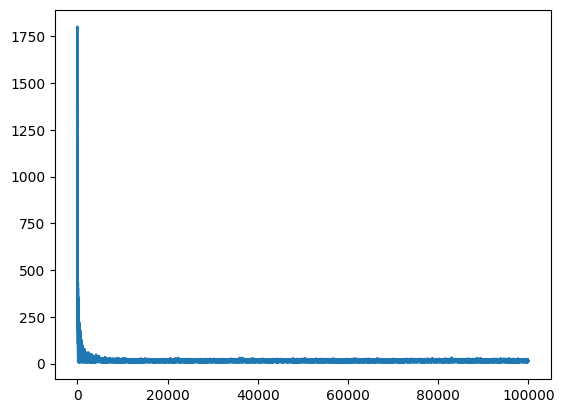

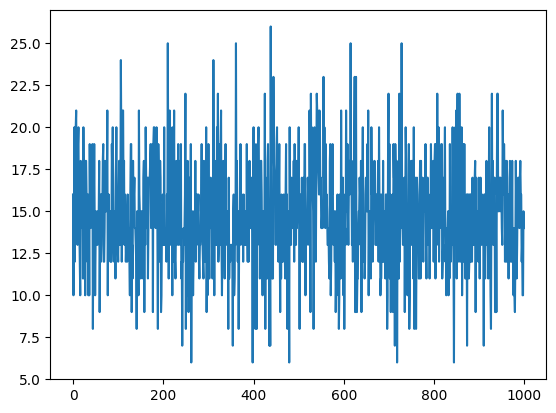

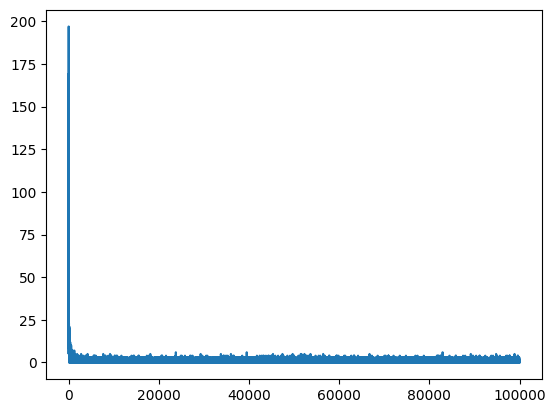

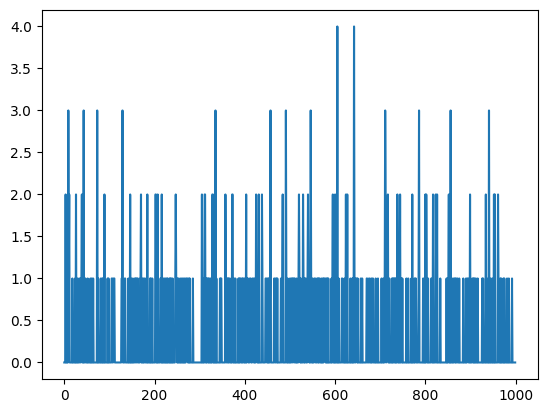

In [7]:
from matplotlib import pyplot as plt

## The number of epochs run in the 100000 training episodes
plt.plot(all_epochs)
plt.show()

## The number of epochs run in the last 1000 training episodes
plt.plot(all_epochs[-1000:])
plt.show()

## The total received penalty  in 100000 training episodes
plt.plot(all_penalties)
plt.show()

## The received penalty  in the last 1000 training episodes
plt.plot(all_penalties[-1000:])
plt.show()


In [8]:
##Evaluate agent's performance after Q-learning
## give a task
# taxi at (row=0, column=0) , passenger at index=2 (Y), destination is index=1 (G))
state = env.encode(0, 0, 2, 1)
print("State:", state)

env.s = state
env.render()

State: 9
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [18]:
## Solve the task state =9
epochs = 0
env.s = 9  # set task to be at state 9
 ### (taxi at (row=0, column=0) , passenger at index=2 (Y), destination is index=1 (G))

penalties, reward = 0, 0

frames = [] # for animation

done = False

total_reward = 0

while not done:
    action = np.argmax(q_table[state])  ## find the best action
    state, reward, done, info = env.step(action)   ## take the action

    total_reward += reward

    if reward == -10:
       penalties += 1

      # Put each rendered frame into dict for animation
    frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }
      )

    epochs += 1

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))
print("Total reward (money earned):", total_reward)

Timesteps taken: 14
Penalties incurred: 0
Total reward (money earned): 7


In [10]:
## see how the taxi moves to pickup the passenger and send to the destination
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(2.5)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 85
Action: 5
Reward: 20


In [19]:
## Check the Q-table we have, when the taxi starts at state=9, which action is the best to take?
q_table[9]
np.argmax(q_table[9])

0

In [12]:
## give another task
epochs = 0
env.s = 332  # set task to be at state 332
env.render()
# taxi at (row=3, column=1) , passenger at index=3 (B), destination is index=0 (R))


penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = np.argmax(q_table[state])  ## find the best action
    state, reward, done, info = env.step(action)   ## take the action

    if reward == -10:
       penalties += 1

      # Put each rendered frame into dict for animation
    frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }
      )

    epochs += 1

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Timesteps taken: 16
Penalties incurred: 0


In [13]:
## illustrate all the frames. see how the taxi moves to pickup the passenger and send to the destination
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 16
State: 0
Action: 5
Reward: 20


In [21]:
## Check the Q-table we have, when the taxi starts at state=332, which action is the best to take?
q_table[332]
np.argmax(q_table[332])

1

In [23]:
# Run 100 tasks (episodes)
## see on average, how the agent performs

total_epochs, total_penalties = 0, 0
episodes = 100

total_reward_earned = 0
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    episode_reward = 0

    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        episode_reward += reward

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
    total_reward_earned += episode_reward


print(f"Results of {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
average_reward_per_episode = total_reward_earned / episodes
print("Average reward per episode:", average_reward_per_episode)




Results of 100 episodes:
Average timesteps per episode: 12.98
Average penalties per episode: 0.0
Average reward per episode: 8.02


### Changing hyperparameters

Episode: 10000
Training finished.



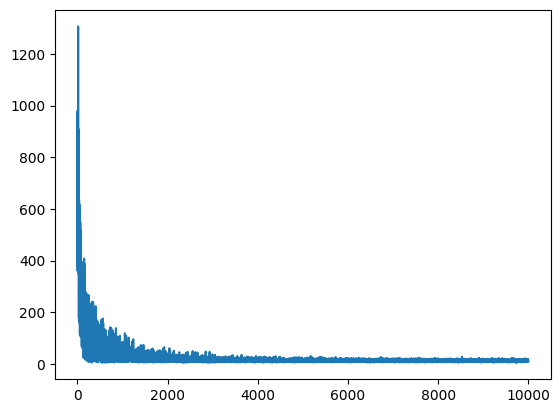

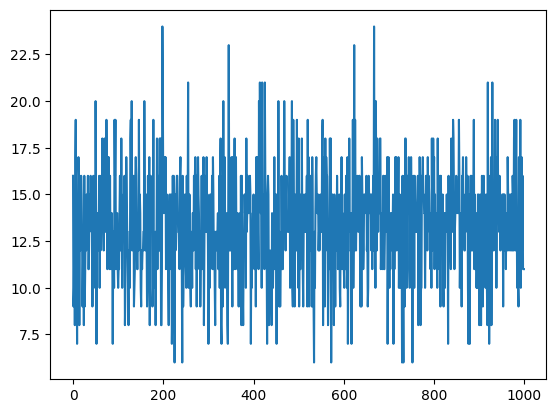

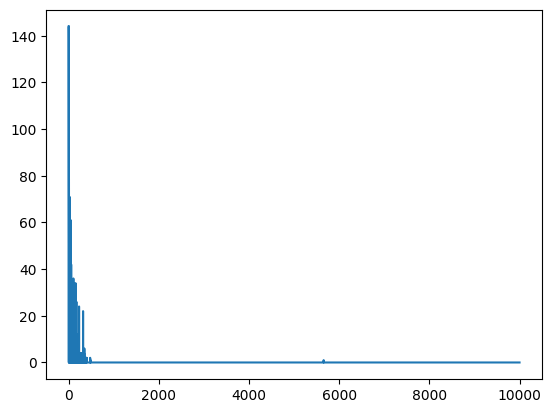

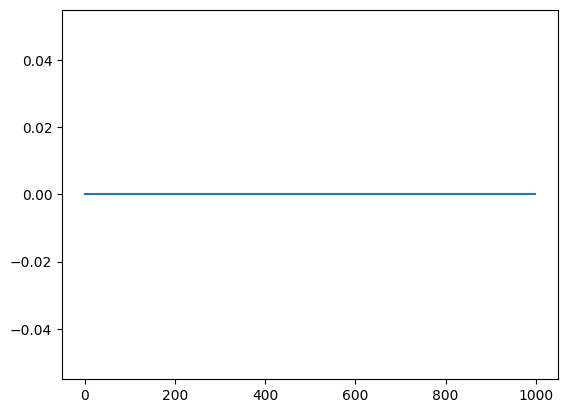

In [15]:
import numpy as np

import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

env = gym.make('Taxi-v3').env
env.reset()
env.render()

q_table = np.zeros([env.observation_space.n, env.action_space.n])

alpha = 0.1
gamma = 0.6
epsilon = 0.000001  # Changed epsilon

# For plotting metrics
all_epochs = []
all_penalties = []

# Training for 10000 episodes
for i in range(1, 10001):  # Changed number of episodes
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    all_epochs.extend([epochs])
    all_penalties.extend([penalties])

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

## The number of epochs run in the 100000 training episodes
plt.plot(all_epochs)
plt.show()

## The number of epochs run in the last 1000 training episodes
plt.plot(all_epochs[-1000:])
plt.show()

## The total received penalty  in 100000 training episodes
plt.plot(all_penalties)
plt.show()

## The received penalty  in the last 1000 training episodes
plt.plot(all_penalties[-1000:])
plt.show()


In [34]:
total_epochs = 0
episodes = 100
unsolvable_tasks = 0

total_penalties = 0
total_reward_earned = 0

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    episode_reward = 0

    done = False

    max_steps = 20001

    while not done and epochs < max_steps:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        episode_reward += reward

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
    total_reward_earned += episode_reward

average_epochs = total_epochs / episodes

print(f"Results of {episodes} episodes:")
print(f"Average timesteps per episode: {average_epochs}")

Results of 100 episodes:
Average timesteps per episode: 1411.6


In [22]:
total_epochs = 0
episodes = 100
num_tasks = 0
unsolvable_tasks = []

for _ in range(episodes):
    state = env.reset()
    epochs = 0
    done = False

    for _ in range(1000):  # Maximum 1000 steps per episode
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
        epochs += 1
        if done:
            break

    if not done:
        num_tasks += 1  # Count unsolvable tasks
        unsolvable_tasks.append(state)

    total_epochs += epochs

average_epochs = total_epochs / episodes

print(f"Results of {episodes} episodes:")
print(f"Average timesteps per episode: {average_epochs}")
print(f"Number of unsolvable tasks: {num_tasks}")

Results of 100 episodes:
Average timesteps per episode: 82.25
Number of unsolvable tasks: 7


In [25]:
print(unsolvable_tasks)
for state in unsolvable_tasks:
  row, col, passenger_idx, dest_idx = env.decode(state)
  print(f"State {state}: Taxi at ({row}, {col}), Passenger at {passenger_idx} ({['R', 'G', 'Y', 'B'][passenger_idx]}), Destination at {dest_idx} ({['R', 'G', 'Y', 'B'][dest_idx]})")

[12, 13, 92, 91, 107, 488, 29]
State 12: Taxi at (0, 0), Passenger at 3 (B), Destination at 0 (R)
State 13: Taxi at (0, 0), Passenger at 3 (B), Destination at 1 (G)
State 92: Taxi at (0, 4), Passenger at 3 (B), Destination at 0 (R)
State 91: Taxi at (0, 4), Passenger at 2 (Y), Destination at 3 (B)
State 107: Taxi at (1, 0), Passenger at 1 (G), Destination at 3 (B)
State 488: Taxi at (4, 4), Passenger at 2 (Y), Destination at 0 (R)
State 29: Taxi at (0, 1), Passenger at 2 (Y), Destination at 1 (G)
